# Final figures for PIK3CA story
### Proteomic abundance

### Standard Imports

In [28]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import json
import operator

#import the Endometrial data from CPTAC package
import CPTAC.Endometrial as CPTAC

### Get proteomics data and somatic mutations from CPTAC

In [106]:
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()

### Make Proteomics box plot for AKT1, AKT2, PTEN, PIK3CA
##### Show data for hotspot mutations vs all other mutations or wildtype

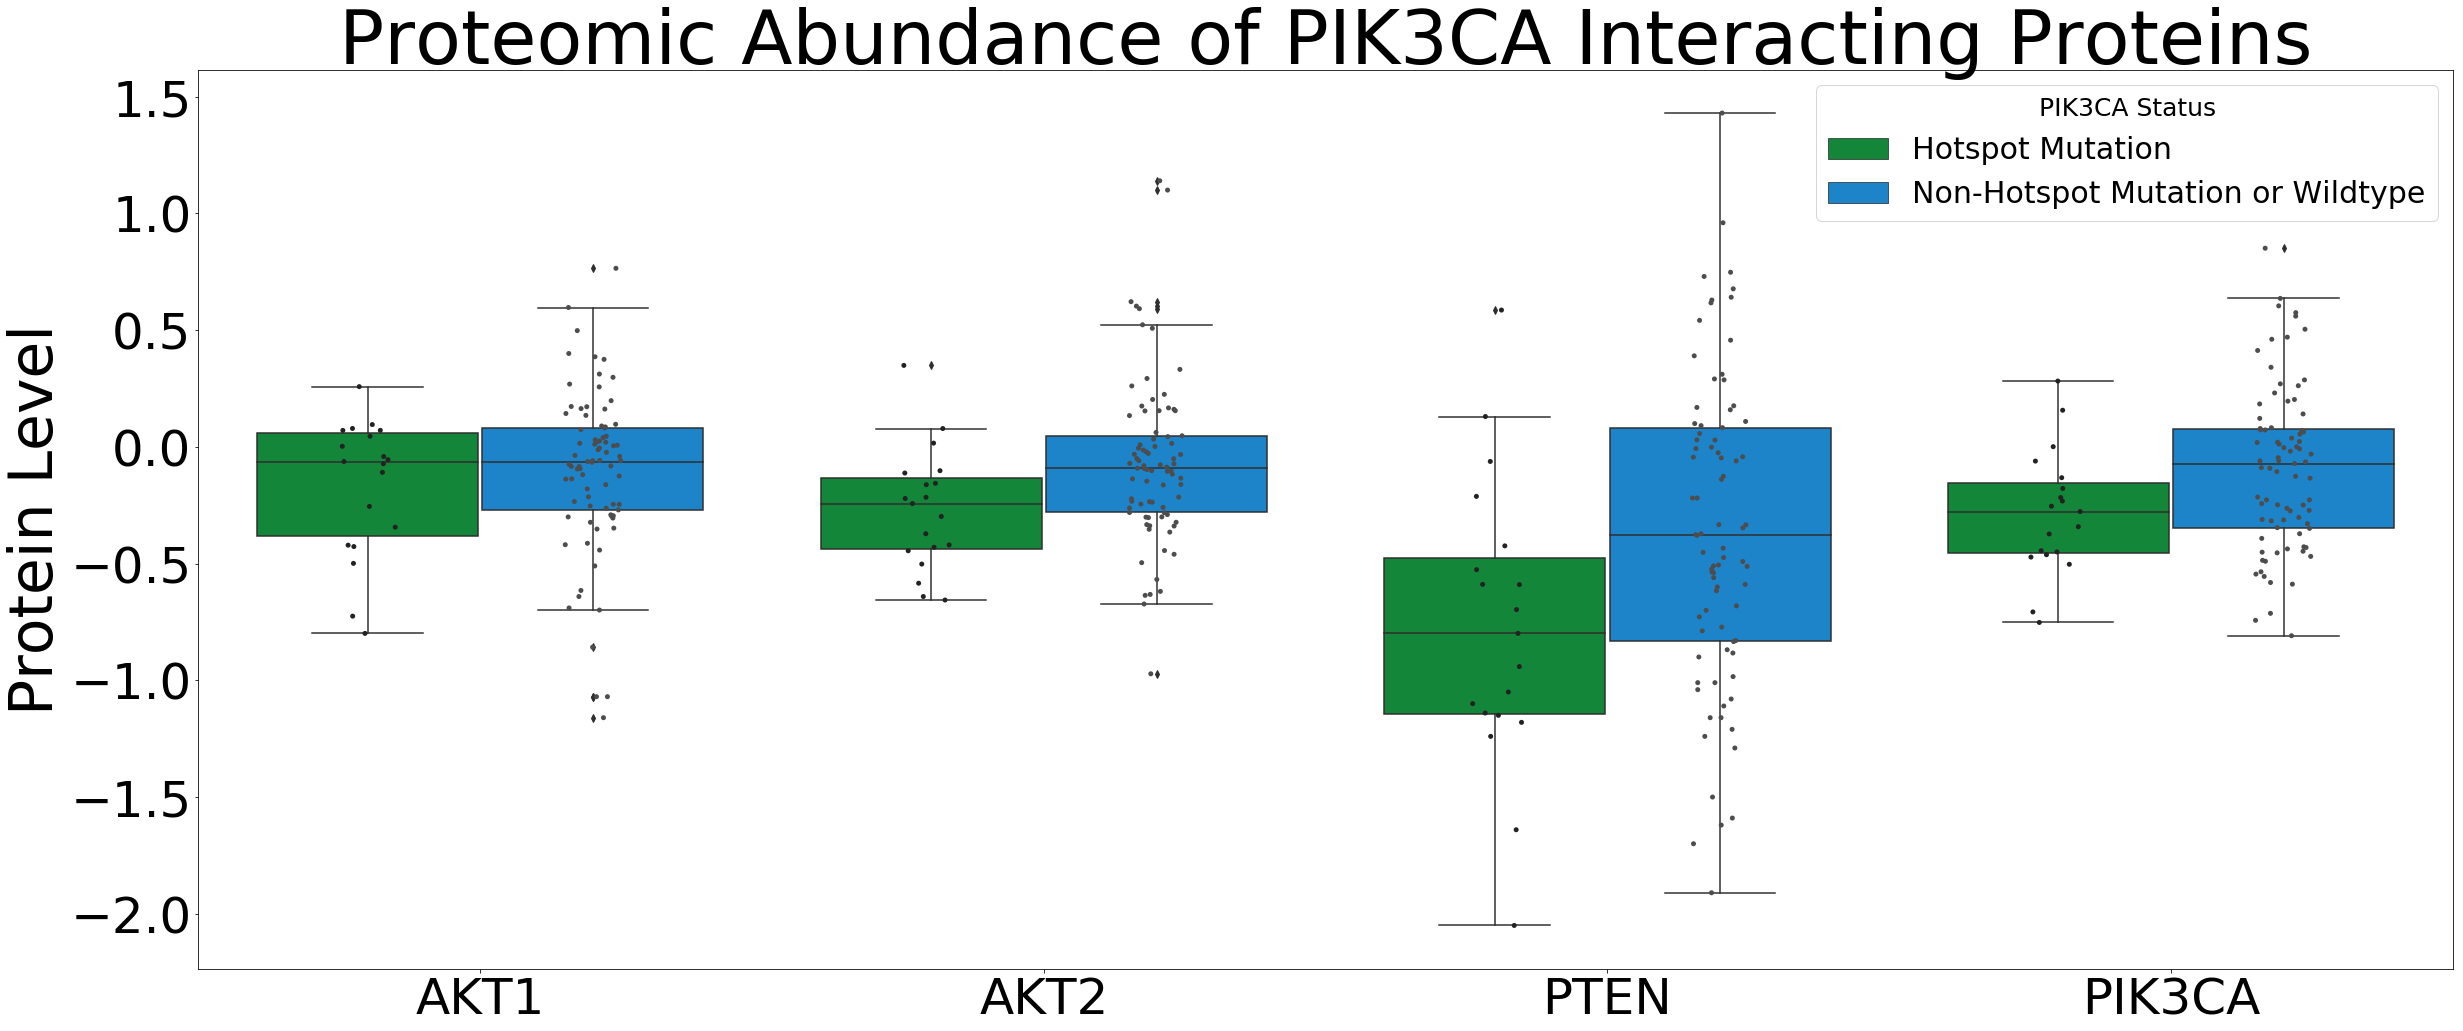

In [108]:
'''Use PIK3CA as gene, AKT1, AKT2, PTEN, and PIK3CA as proteins'''
gene = 'PIK3CA'
protList = ['AKT1','AKT2','PTEN','PIK3CA']

'''A list of mutations present in the hotspot according to our Hotspot3D output'''
hotspot_mutations = ['p.E545A', 'p.E545K', 'p.E545V', 'p.Q546P', 'p.Q546R', 'p.E542K']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']

'''Get the PIK3CA mutation dataframe'''
plotdf = CPTAC.compare_mutations(proteomics, gene)

'''Look only at Tumor patients'''
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]

'''Add in the protein levels for every protein in the list'''
for protein in protList:
    proteindf = CPTAC.compare_mutations(proteomics, protein, gene)
    proteindf = proteindf.loc[proteindf['Patient_Type'] == 'Tumor']
    proteindf = proteindf[[protein]]
    plotdf = plotdf.join(proteindf)

'''Reformat the dataframe to classify Hotspot Mutations, and all other types'''
for ind, row in plotdf.iterrows():
    if ind in hotspot_patients.values:
        #plotdf.set_value(ind,'Mutation', 'Hotspot Mutation')
        plotdf.at[ind, 'Mutation'] = 'Hotspot Mutation'
    else:
        plotdf.at[ind, 'Mutation'] = 'Non-Hotspot Mutation or Wildtype'


'''Reformat dataframe for plot'''
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Protein', value_name='Signal')
plotdf = plotdf.dropna(axis=0)

'''Create the plot'''
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Hotspot Mutation": "#009933", "Non-Hotspot Mutation or Wildtype": "#008ae6"}
boxplt = sns.boxplot(x='Protein', y='Signal', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Protein', y='Signal', hue='Mutation', dodge=True, jitter=True, color='.3')
boxplt.set_xlabel('')
boxplt.set_ylabel('Protein Level', fontsize='60')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Proteomic Abundance of PIK3CA Interacting Proteins', fontsize = '75')

'''Adjust the legend'''
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Hotspot Mutation', 'Non-Hotspot Mutation or Wildtype'], title='PIK3CA Status', fontsize='30', frameon=True)
boxplt.get_legend().get_title().set_fontsize('25')


'''Show Plot'''
fig = boxplt.get_figure()
plt.show()

## Make Proteomics Volcano Plot
#### Hotspot mutation vs other mutations or wildtype, all interacting proteins

P-Value Cutoff:  0.0033333333333333335
[-0.10195990903183888, -0.43756955165692013, -0.32607641910331386, -0.19974630929174783, -0.09009179987004551, -0.4106004223521768, -0.060792274204028524, -0.2355550162443144, -0.1759408450704225, -0.05335903898635479, 0.13756545808966864, -0.19373634372969462, -0.1208605380116959, -0.16364632878492527, 0.11385693567251468]
[0.5035367810301701, 0.02552212534819076, 0.01780099029991586, 0.021090262225409967, 0.5506198001682362, 0.01581066819387846, 0.481215853185884, 0.22843119672475806, nan, 0.5440733573821175, 0.24882209547901762, 0.025359967628122704, 0.021477271861438874, 0.2347027612863359, 0.104981612666904]


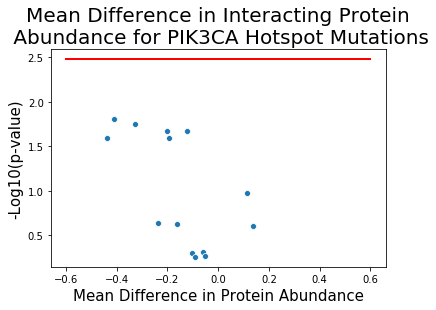

In [126]:
gene = 'PIK3CA'
protList = ['IRS1', 'IRS2', 'RRAS', 'AKT2', 'NRAS', 'PTEN', 'AKT1', 'MRAS', 'HRAS', 'RPS6KB1', 'PIK3R1', 'PIK3CA','MTOR', 'ERBB3', 'CDK5']
p_value_cutoff = .05/len(protList)
print("P-Value Cutoff: ", p_value_cutoff)
'''A list of mutations present in the hotspot according to our Hotspot3D output'''
hotspot_mutations = ['p.E545A', 'p.E545K', 'p.E545V', 'p.Q546P', 'p.Q546R', 'p.E542K']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']

'''Get the PIK3CA mutation dataframe'''
plotdf = CPTAC.compare_mutations(proteomics, gene)

'''Look only at Tumor patients'''
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]

'''Add in the protein levels for every protein in the list'''
for protein in protList:
    proteindf = CPTAC.compare_mutations(proteomics, protein, gene)
    proteindf = proteindf.loc[proteindf['Patient_Type'] == 'Tumor']
    proteindf = proteindf[[protein]]
    plotdf = plotdf.join(proteindf)

'''Reformat the dataframe to classify Hotspot Mutations, and all other types'''
for ind, row in plotdf.iterrows():
    if ind in hotspot_patients.values:
        #plotdf.set_value(ind,'Mutation', 'Hotspot Mutation')
        plotdf.at[ind, 'Mutation'] = 'Hotspot Mutation'
    else:
        plotdf.at[ind, 'Mutation'] = 'Non-Hotspot Mutation or Wildtype'

diff_means = []
p_values = []

for prot in plotdf:
    if prot != "Mutation":
        hotspotdf = plotdf.loc[plotdf['Mutation'] == 'Hotspot Mutation']
        otherdf = plotdf.loc[plotdf['Mutation'] != 'Hotspot Mutation']
        
        ttest = scipy.stats.ttest_ind(hotspotdf[prot], otherdf[prot])
        p_values.append(ttest[1])
        
        hotspot_mean = np.mean(hotspotdf[prot])
        other_mean = np.mean(otherdf[prot])
        mean_diff = hotspot_mean - other_mean
        diff_means.append(mean_diff)
        
print(diff_means)
print(p_values)

neg_log_pvals = []
for item in p_values:
    neg_log_pvals.append(-1 * np.log10(item))

df = pd.DataFrame({'-Log10(p-value)': neg_log_pvals, 'Mean Difference in Protein Abundance':diff_means, 'Protein':protList})
bonferroniCutoff= p_value_cutoff
cutoffLine = (-1* np.log10(bonferroniCutoff))

a4_dims = (12, 7.5)
#fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.scatterplot(x = "Mean Difference in Protein Abundance", y = "-Log10(p-value)", data =df)
ax.set_title("Mean Difference in Interacting Protein\n Abundance for PIK3CA Hotspot Mutations", fontsize = '20')
ax.set_xlabel('Mean Difference in Protein Abundance', fontsize = '15')
ax.set_ylabel('-Log10(p-value)', fontsize='15')
ax.plot([-.6,.6],[cutoffLine,cutoffLine], linewidth=2, color="red")
plt.show()